In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8.1 to 10.13 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('parsec3_3.dat',format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
# kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

In [4]:
# Diane's Ages
pdfout = fits.getdata('LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [5]:
#Transform gaia ra and dec to L and B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [6]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

In [8]:
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [6]:
plt.scatter(np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]),parsec['logAge'])

NameError: name 'sol_xm' is not defined

(array([ 571., 1438., 1872., 1819., 1788., 1539., 1538., 1164.,  980.,
        2237.]),
 array([-0.83855053, -0.75928028, -0.68001003, -0.60073979, -0.52146954,
        -0.44219929, -0.36292904, -0.28365879, -0.20438854, -0.12511829,
        -0.04584805]),
 <a list of 1 Patch objects>)

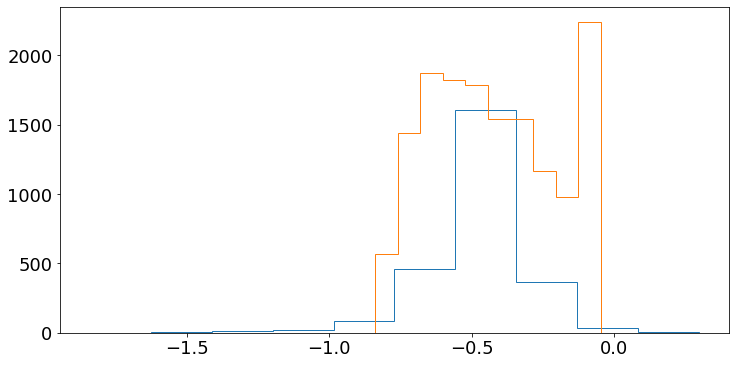

In [45]:
plt.hist(r13['C_FE']-r13['N_FE'],histtype='step')
plt.hist(np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]),histtype='step')

<font size='5'>
    <p style='color:blue'>
        <b>
            PCA
        </b>    
    </p>    
</font>

In [46]:
data = np.array([parsec['logTe'],np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]),
                 parsec['MH'],parsec['logg']]).T
# data = np.array([parsec['Jmag']-parsec['Ksmag'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T

# new_data = KernelPCA(n_components=2).fit(data).transform(data)

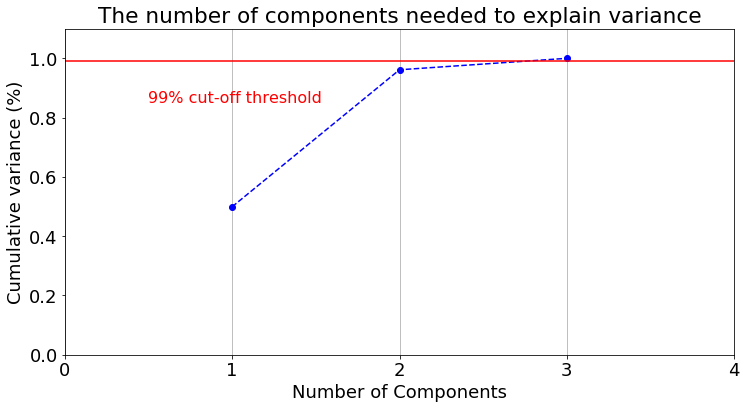

In [47]:
pca = PCA(n_components=3).fit(data)#_rescaled)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

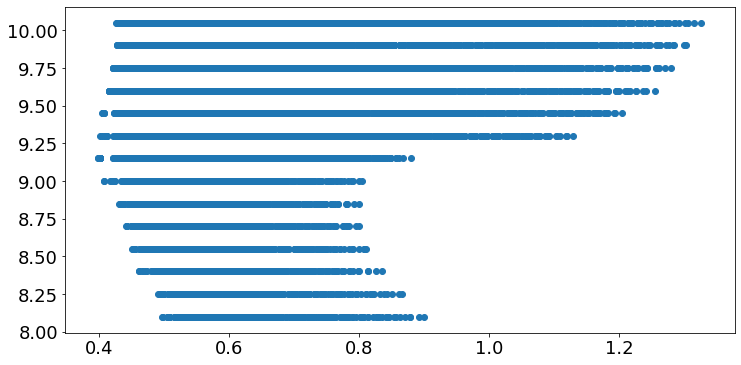

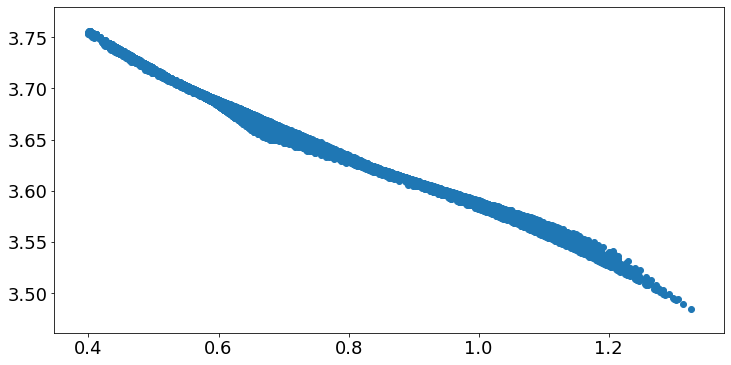

In [48]:
plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['logAge'])
plt.show()

plt.scatter(parsec['Jmag']-parsec['Ksmag'],parsec['logTe'])

In [8]:
data = np.array([parsec['logTe'],parsec['Ksmag'],
                 np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]),parsec['MH'],parsec['logg']]).T

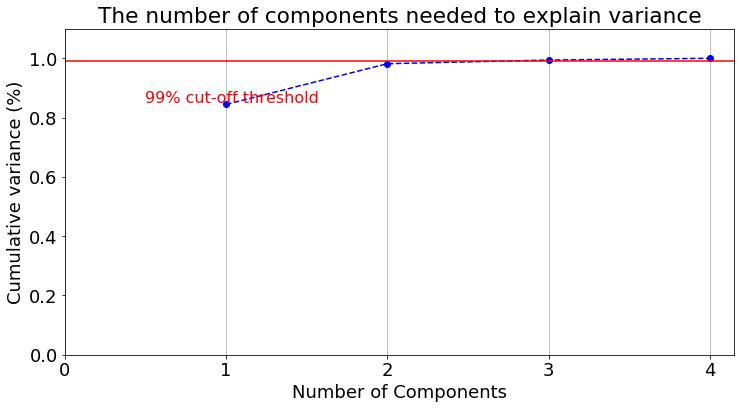

In [22]:
pca = PCA(n_components=4).fit(data)
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(pca.explained_variance_ratio_)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 5, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.85, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [55]:
#transform data to new basis
new_data = PCA(n_components=3).fit(data).transform(data)

#create new variables
x1 = new_data[:,0]
x2 = new_data[:,1]
x3 = new_data[:,2]
# x4 = new_data[:,3]
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
# x14 = np.multiply(x1,x4)
x23 = np.multiply(x2,x3)
# x24 = np.multiply(x3,x4)
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
# x4sq = x4**2
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3
# x4cu = x4**3

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x12','x13','x23','x1sq','x2sq','x3sq','x1cu','x2cu','x3cu']
all_var = [x1,x2,x12,x13,x23,x1sq,x2sq,x3sq,x1cu,x2cu,x3cu]
# all_var_str = ['x1','x2','x12','x13','x14','x23','x24','x34','x1sq','x2sq','x3sq','x4sq','x1cu','x2cu','x3cu','x4cu']
# all_var = [x1,x2,x12,x13,x14,x23,x24,x34,x1sq,x2sq,x3sq,x4sq,x1cu,x2cu,x3cu,x4cu]
for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

In [56]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
mads = []
res_span = []
resids = []
summaries = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    res_span.append(max(residual)-min(residual))
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    mads.append(afunc.mad(residual))
    summaries.append(model.summary())
    
idx = np.asarray(res_span).argmin()

['x23']
0.30003441588223456
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 3.461e-05
Date:                Tue, 05 May 2020   Prob (F-statistic):              0.995
Time:                        22:07:38   Log-Likelihood:                -11063.
No. Observations:               14946   AIC:                         2.213e+04
Df Residuals:                   14944   BIC:                         2.214e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4080   

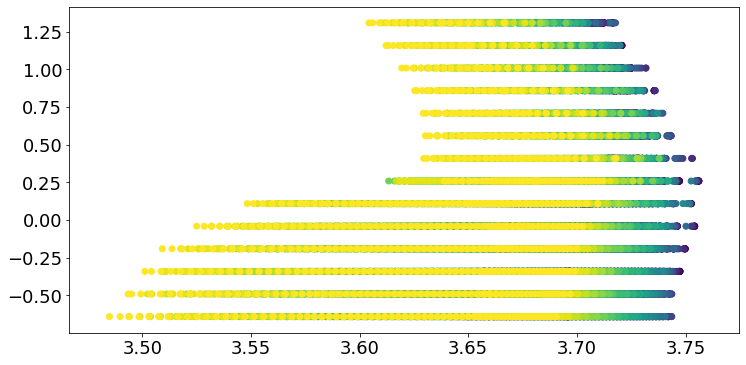

In [57]:
print(models_str[idx])
print(mads[idx])
print(summaries[idx])

plt.scatter(parsec['logTe'],resids[idx],c=parsec['MH'])


['x1' 'x2' 'x3' 'x4' 'x12' 'x14' 'x23' 'x24' 'x34' 'x4sq' 'x2cu' 'x3cu'
 'x4cu']
0.0472845491032432
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        21:42:49   Log-Likelihood:                 6961.7
No. Observations:               14946   AIC:                        -1.390e+04
Df Residuals:                   14932   BIC:                        -1.379e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

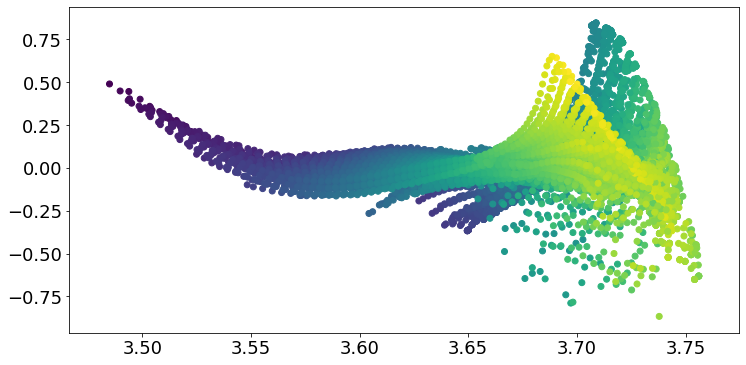

In [39]:
# new_data = ()#PCA(n_components=3).fit(data).transform(data)

###
### Keep
###

# x1 = parsec['logTe']#new_data[:,0]
# x2 = np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1])
# x3 = parsec['MH'] #new_data[:,2]
# x4 = parsec['logg']
# x12 = np.multiply(x1,x2)
# x13 = np.multiply(x1,x3)
# x14 = np.multiply(x1,x4)
# x23 = np.multiply(x2,x3)
# x24 = np.multiply(x2,x4)
# x34 = np.multiply(x3,x4)
# x1sq = x1**2
# x2sq = x2**2
# x3sq = x3**2
# x4sq = x4**2
# x1cu = x1**3
# x2cu = x2**3
# x3cu = x3**3
# x4cu = x4**3

# #find all possible models
# models = []
# models_str = []
# all_var_str = ['x1','x2','x3','x4','x12','x13','x14','x23','x24','x34','x1sq','x2sq','x3sq','x4sq','x1cu','x2cu','x3cu','x4cu']
# all_var = [x1,x2,x3,x4,x12,x13,x14,x23,x24,x34,x1sq,x2sq,x3sq,x4sq,x1cu,x2cu,x3cu,x4cu]
# for i in range(4, len(all_var)+1):
#     for subset in it.combinations(all_var,i):
#         models.append(subset)
#     for subset_str in it.combinations(all_var_str,i):
#         models_str.append(np.array(subset_str))
    
# idx = []
# for j in range(len(models_str)):
#     if models_str[j][0]=='x1' and models_str[j][1]=='x2' and models_str[j][2]=='x3' and models_str[j][3]=='x4':
#         idx.append(j)
        
# models = np.array(models)[idx]
# models_str = np.array(models_str)[idx]

# ######################
# ### Fit All Models ###
# ######################

# import statsmodels.api as sm 

# all_params = []
# mads = []
# resids = []
# summaries = []
# for i in tqdm_notebook(range(len(models)),desc='Done?'):
#     pmodl = np.array(models[i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(parsec['logAge'],pmodl).fit()
#     predictions = model.predict(pmodl)
#     residual = predictions - parsec['logAge']
#     resids.append(residual)
#     all_params.append(np.asarray(model.params))
#     mads.append(afunc.mad(residual))
#     summaries.append(model.summary())
    
# idx = np.asarray(mads).argmin()

# print(models_str[idx])
# print(mads[idx])
# print(summaries[idx])

# plt.scatter(parsec['logTe'],resids[idx],c=parsec['logg'])

In [9]:
x1 = parsec['logTe']
x2 = parsec['Ksmag']
x3 = parsec['MH']
x4 = parsec['logg']
x5 = np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1])

x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x14 = np.multiply(x1,x4)
x15 = np.multiply(x1,x5)

x23 = np.multiply(x2,x3)
x24 = np.multiply(x2,x4)
x25 = np.multiply(x2,x5)

x34 = np.multiply(x3,x4)
x35 = np.multiply(x3,x5)

x45 = np.multiply(x4,x5)

x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x4sq = x4**2
x5sq = x5**2

x1cu = x1**3
x2cu = x2**3
x3cu = x3**3
x4cu = x4**3
x5cu = x5**3

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x4','x5','x12','x13','x14','x15','x23','x24','x25','x34','x35','x45','x1sq','x2sq',
               'x3sq','x4sq','x5sq','x1cu','x2cu','x3cu','x4cu','x5cu']
all_var = [x1,x2,x3,x4,x5,x12,x13,x14,x15,x23,x24,x25,x34,x35,x45,x1sq,x2sq,x3sq,x4sq,x5sq,x1cu,x2cu,x3cu,x4cu,
           x5cu]
for i in tqdm_notebook(range(5, len(all_var)+1),desc='done'):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))

In [10]:
idx = []
for j in tqdm_notebook(range(len(models_str)),desc='done'):
    if (models_str[j][0]=='x1' and models_str[j][1]=='x2' and models_str[j][2]=='x3' and models_str[j][3]=='x4'
        and models_str[j][4]=='x5'):
        idx.append(j)
        
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

In [ ]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
mads = []
resids = []
summaries = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    mads.append(afunc.mad(residual))
    summaries.append(model.summary())
    
idx = np.asarray(mads).argmin()

['x1' 'x2' 'x3' 'x4' 'x12' 'x14' 'x23' 'x24' 'x34' 'x4sq' 'x2cu' 'x3cu'
 'x4cu']
0.0472845491032432
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                 1.166e+04
Date:                Tue, 05 May 2020   Prob (F-statistic):               0.00
Time:                        21:25:01   Log-Likelihood:                 6961.7
No. Observations:               14946   AIC:                        -1.390e+04
Df Residuals:                   14932   BIC:                        -1.379e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

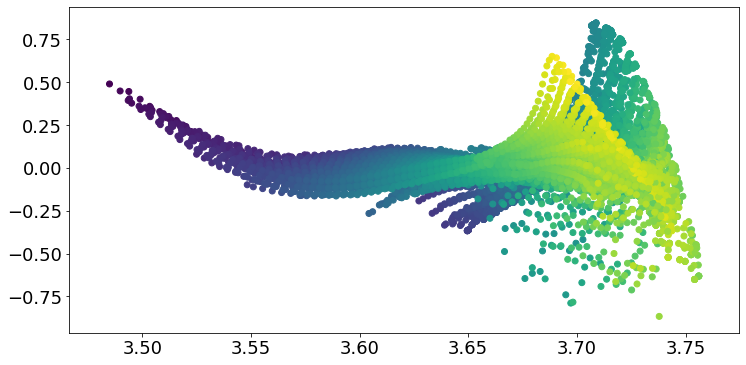

In [37]:
print(models_str[idx])
print(mads[idx])
print(summaries[idx])

plt.scatter(parsec['logTe'],resids[idx],c=parsec['logg'])


['x1' 'x2' 'x3' 'x4' 'x13' 'x14' 'x24' 'x34' 'x1sq' 'x2sq' 'x3sq' 'x1cu'
 'x2cu' 'x3cu' 'x4cu']
0.032293220965129876
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 5.942e+04
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:20:27   Log-Likelihood:                 19621.
No. Observations:               14946   AIC:                        -3.921e+04
Df Residuals:                   14930   BIC:                        -3.909e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

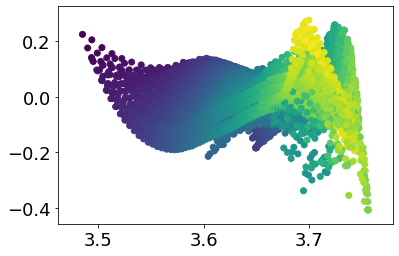

In [9]:
x1 = parsec['logTe']#new_data[:,0]
x2 = parsec['Ksmag']
x3 = parsec['MH'] #new_data[:,2]
x4 = np.log10(parsec['Xc']/sol_xm[0])-np.log10(parsec['Xn']/sol_xm[1]) #parsec['logg']
x12 = np.multiply(x1,x2)
x13 = np.multiply(x1,x3)
x14 = np.multiply(x1,x4)
x23 = np.multiply(x2,x3)
x24 = np.multiply(x2,x4)
x34 = np.multiply(x3,x4)
x1sq = x1**2
x2sq = x2**2
x3sq = x3**2
x4sq = x4**2
x1cu = x1**3
x2cu = x2**3
x3cu = x3**3
x4cu = x4**3

#find all possible models
models = []
models_str = []
all_var_str = ['x1','x2','x3','x4','x12','x13','x14','x23','x24','x34','x1sq','x2sq','x3sq','x4sq','x1cu','x2cu','x3cu','x4cu']
all_var = [x1,x2,x3,x4,x12,x13,x14,x23,x24,x34,x1sq,x2sq,x3sq,x4sq,x1cu,x2cu,x3cu,x4cu]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='x1' and models_str[j][1]=='x2' and models_str[j][2]=='x3' and models_str[j][3]=='x4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str = np.array(models_str)[idx]

######################
### Fit All Models ###
######################

import statsmodels.api as sm 

all_params = []
mads = []
resids = []
summaries = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    mads.append(afunc.mad(residual))
    summaries.append(model.summary())
    
idx = np.asarray(mads).argmin()

print(models_str[idx])
print(mads[idx])
print(summaries[idx])

plt.scatter(parsec['logTe'],resids[idx],c=parsec['logg'])

In [51]:
from sklearn.cross_decomposition import PLSRegression

pls2 = PLSRegression(n_components=1)
pls2.fit(data, parsec['logAge'])
# PLSRegression()
Y_pred = pls2.predict(data)

afunc.mad(Y_pred - parsec['logAge'])

0.41628012443496054